# Notebook to read multiple h5ad files and merge them into single anndata object for downstream analysis

**Developed by** : Srivalli Kolla

**Würzburg Institute for Systems Immunology - JMU-Würzburg**

**Created on** : April 05, 2024

**Modified on** : April 08,2024

# Importing packages

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
import time
import matplotlib.pyplot as plt

# Setting up environment

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor="white")

/Users/srivalli/conda/envs/scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.8 anndata==0.10.5.post1 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.10.8 louvain==0.8.1 pynndescent==0.5.11


# Importing Data

In [3]:
vascular = ad.read_h5ad('../Data/hca_heart_vascular_raw.h5ad')
vascular

AnnData object with n_obs × n_vars = 195395 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

### Looking at overall counts based on 'cell_type'

In [4]:
crosstab = pd.crosstab(vascular.obs['sample'],vascular.obs['cell_type'])

(array([-2000.,     0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(0, -2000.0, '−2000'),
  Text(0, 0.0, '0'),
  Text(0, 2000.0, '2000'),
  Text(0, 4000.0, '4000'),
  Text(0, 6000.0, '6000'),
  Text(0, 8000.0, '8000'),
  Text(0, 10000.0, '10000')])

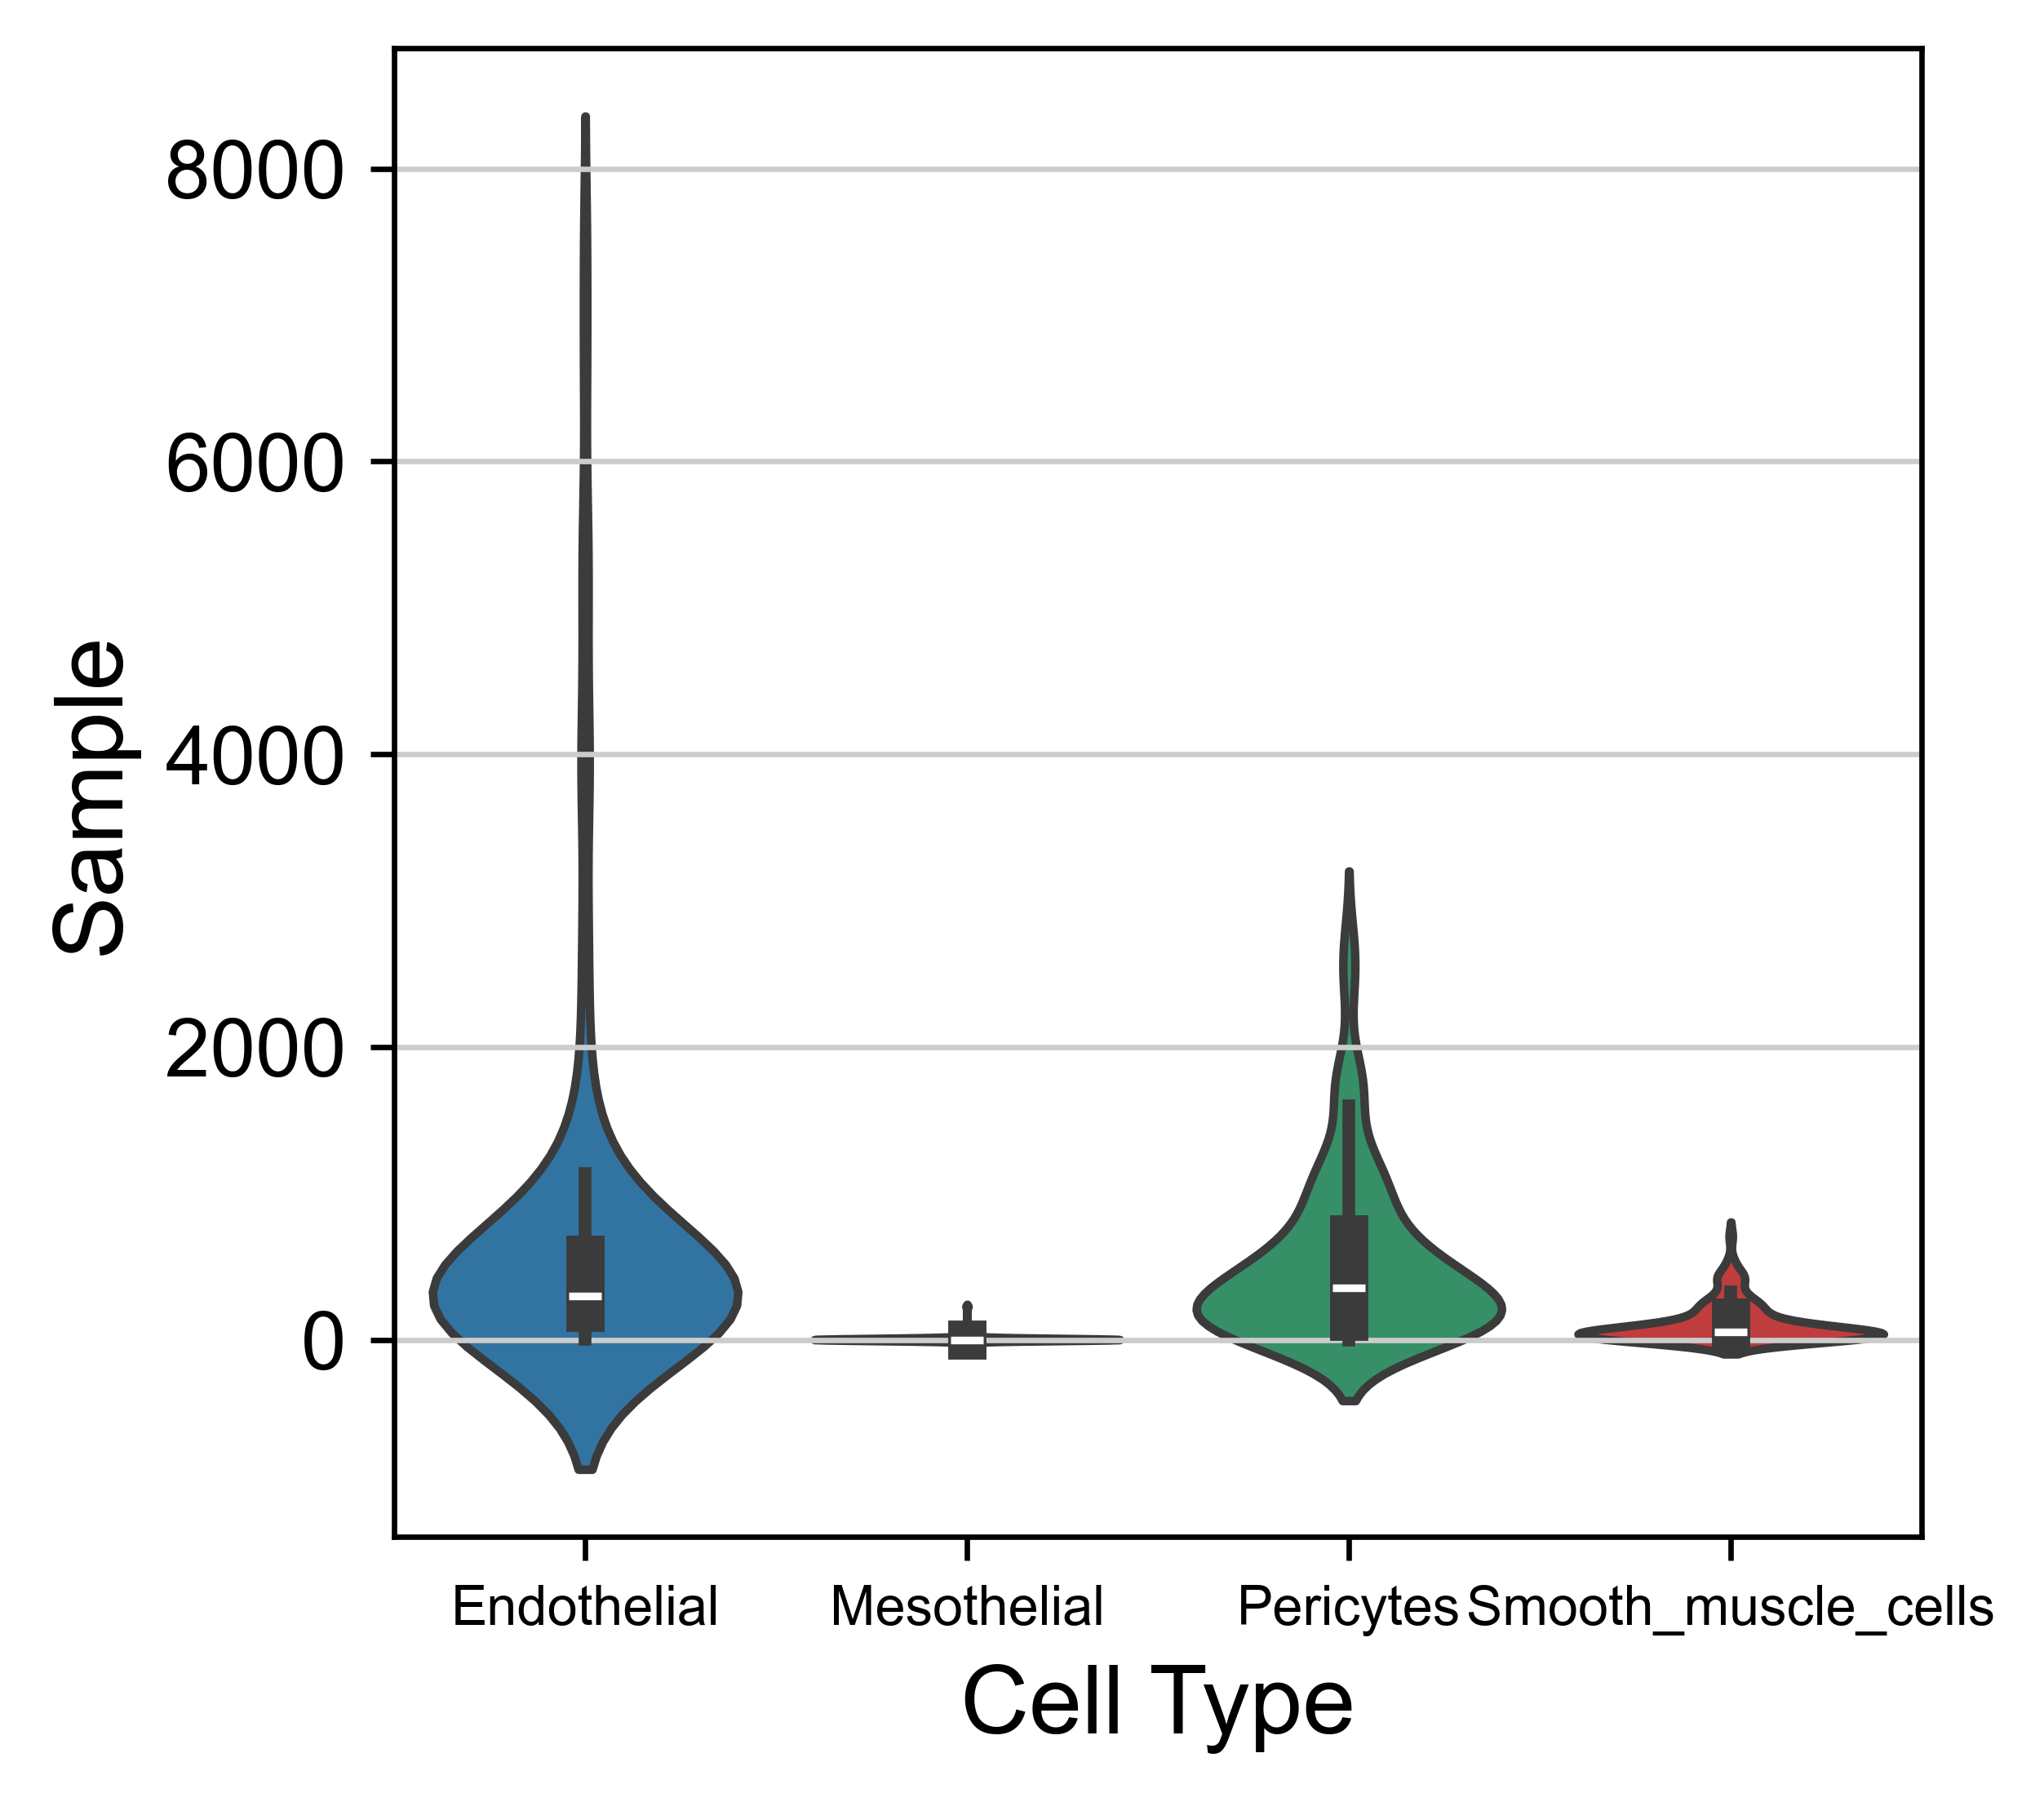

In [5]:
sns.violinplot(crosstab)

# Adjust font size of axes labels and ticks

plt.xlabel('Cell Type', fontsize=14)
plt.ylabel('Sample', fontsize=14)
plt.xticks(fontsize=8)
plt.yticks(fontsize=12)

### Selecting samples having pericytes only

In [6]:
pericytes = vascular[vascular.obs['cell_type'] == "Pericytes"]
pericytes

View of AnnData object with n_obs × n_vars = 77856 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

### Checking the subsetting

In [7]:
crosstab = pd.crosstab(vascular.obs['sample'],vascular.obs['cell_type']=='Pericytes')
crosstab

cell_type,False,True
sample,,
H0015_LA_new,342,495
H0015_LV,879,1889
H0015_RA,413,152
H0015_RV,428,1267
H0015_apex,1002,1508
...,...,...
HCAHeart8287124,10,45
HCAHeart8287125,33,7
HCAHeart8287126,364,552


### Checking the count

In [8]:
column_sum = crosstab.sum()
column_sum

cell_type
False    117539
True      77856
dtype: int64

## Data categorization

### Sample wise categorization

In [9]:
sample_names = pericytes.obs['sample'].unique()
sample_names

['HCAHeart7606896', 'HCAHeart7656534', 'HCAHeart7656535', 'HCAHeart7656536', 'HCAHeart7656537', ..., 'H0037_RA_corr', 'H0037_LV', 'H0037_LA_corr', 'H0037_RV', 'H0037_septum']
Length: 145
Categories (145, object): ['H0015_LA_new', 'H0015_LV', 'H0015_RA', 'H0015_RV', ..., 'HCAHeart8287125', 'HCAHeart8287126', 'HCAHeart8287127', 'HCAHeart8287128']

### Making a loop for h5ad file generation

In [10]:
# Iterate over each unique sample name
for sample_name in sample_names:
    
    # Subsetting data based on the sample
    pericytes_sample_data = pericytes[pericytes.obs['sample'] == sample_name]

    # Timestamp
    timestamp = time.strftime("%d%m%Y")

    # Saving subset of each sample as separate H5AD file
    pericytes_sample_data.write_h5ad(f"../PC-Sample_files/PC_{sample_name}_{timestamp}.h5ad")

### Checking anndata files

In [11]:
H0015_LV_08042024 = ad.read_h5ad("../PC-Sample_files/PC_H0015_LA_new_08042024.h5ad")
H0015_LV_08042024

AnnData object with n_obs × n_vars = 495 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

# Reading the sample wise h5ad files

### Creating a list to store sample wise h5ad files

In [12]:
PC_sample_data = []

### Reading files and storing it in list

In [13]:
# Iterate over each unique sample name
for sample_name in sample_names:
    
    # Reading individual h5ad files
    PC_sample_ad_data = ad.read_h5ad(f"../PC-Sample_files/PC_{sample_name}_{timestamp}.h5ad")

    #Appending data of each sample into empty list created
    PC_sample_data.append(PC_sample_ad_data)

PC_sample_data

[AnnData object with n_obs × n_vars = 48 × 33538
     obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
     var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
     uns: 'cell_type_colors'
     obsm: 'X_pca', 'X_umap',
 AnnData object with n_obs × n_vars = 121 × 33538
     obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
     var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-S

# Concatenate all anndata objects

#### Concatenating using merge option to concatenate both obs and var

In [14]:
PC_var = ad.concat(PC_sample_data,label='Sample_number', merge= 'same')
PC_var

AnnData object with n_obs × n_vars = 77856 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used', 'Sample_number'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    obsm: 'X_pca', 'X_umap'

In [15]:
PC_var.var

,gene_ids-Harvard-Nuclei,feature_types-Harvard-Nuclei,gene_ids-Sanger-Nuclei,feature_types-Sanger-Nuclei,gene_ids-Sanger-Cells,feature_types-Sanger-Cells,gene_ids-Sanger-CD45,feature_types-Sanger-CD45
MIR1302-2HG,ENSG00000243485,Gene Expression,ENSG00000243485,0,ENSG00000243485,0,ENSG00000243485,0
FAM138A,ENSG00000237613,Gene Expression,ENSG00000237613,0,ENSG00000237613,0,ENSG00000237613,0
OR4F5,ENSG00000186092,Gene Expression,ENSG00000186092,0,ENSG00000186092,0,ENSG00000186092,0
AL627309.1,ENSG00000238009,Gene Expression,ENSG00000238009,0,ENSG00000238009,0,ENSG00000238009,0
AL627309.3,ENSG00000239945,Gene Expression,ENSG00000239945,0,ENSG00000239945,0,ENSG00000239945,0
...,...,...,...,...,...,...,...,...
AC233755.2,ENSG00000277856,Gene Expression,ENSG00000277856,0,ENSG00000277856,0,ENSG00000277856,0
AC233755.1,ENSG00000275063,Gene Expression,ENSG00000275063,0,ENSG00000275063,0,ENSG00000275063,0
AC240274.1,ENSG00000271254,Gene Expression,ENSG00000271254,0,ENSG00000271254,0,ENSG00000271254,0
AC213203.1,ENSG00000277475,Gene Expression,ENSG00000277475,0,ENSG00000277475,0,ENSG00000277475,0
